Explorer auto sklearn

imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from glob import glob
import IPython.display as ipd
import tensorflow as tf
from PIL import Image
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import keras
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Reshape, InputLayer, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split


In [3]:
df = pd.read_csv("ouiseau/bird_songs_metadata.csv")
class_names = df["name"].unique()

path_to_wav = "ouiseau/wavfiles/"
datafiles = glob(path_to_wav + "*")

def generate_spectrogram(file_audio, identifier):
    audio_data, sample_rate = librosa.load(path_to_wav + file_audio)
    spec_mel = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    spec_mel = librosa.power_to_db(spec_mel, ref=np.max)
    figure, axis = plt.subplots(figsize=(15, 5))
    axis.set_title("Mel Spectrogram")
    plt.suptitle(identifier)
    librosa.display.specshow(spec_mel, x_axis='time', y_axis='log', ax=axis)
    return ipd.Audio(path_to_wav + file_audio, rate=sample_rate)

def process_audio(audio_file):
    audio_data, sample_rate = librosa.load(audio_file, duration=10)
    mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate) 
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec

df_train = pd.DataFrame({"name": df["name"], "audiopath": path_to_wav + df["filename"]})

# Assuming `process_audio` is a function that generates mel spectrograms
df_train["mel_spec"] = df_train["audiopath"].apply(lambda x: process_audio(x))

# Using factorize to encode class labels
df_train["class"] = df_train["name"].factorize()[0]

In [23]:
df_train = shuffle(df_train)
df_train.shape

# Calculate the split index for 80/20 split
split_index = int(0.9 * len(df_train))

# Split the dataset into training and testing sets
(train_x, train_y) = df_train["mel_spec"][:split_index].values, df_train["class"][:split_index].values
(test_x, test_y) = df_train["mel_spec"][split_index:].values, df_train["class"][split_index:].values


# (train_x, train_y) = df_train["mel_spec"][:5000].values, df_train["class"][:5000].values
# (test_x, test_y) = df_train["mel_spec"][5000:].values, df_train["class"][5000:].values

test_y = to_categorical(test_y, num_classes=len(class_names))
train_y = to_categorical(train_y, num_classes=len(class_names))

train_x = np.stack(train_x[:])
test_x = np.stack(test_x[:])

train_x = tf.keras.utils.normalize(train_x)
test_x = tf.keras.utils.normalize(test_x)

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

train_dataset = train_dataset.batch(16)
test_dataset = test_dataset.batch(16)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

solution prof

In [24]:
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    layers.Dense(5, activation="softmax")  # Adjust based on number of bird classes
])

# Compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 12, 12, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │        73,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,389 (939.02 KB)

 Trainable params: 240,389 (939.02 KB)

 Non-trainable params: 0 (0.00 B)

mon test

In [25]:
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(5, activation="softmax")  # Adjust based on number of bird classes
])

# Compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 4, 4, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 716,037 (2.73 MB)

 Trainable params: 716,037 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile('adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(), 'accuracy'])

In [27]:
hist = model.fit(train_dataset, epochs=25, validation_data=test_dataset)

Epoch 1/25


305/305 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.2568 - loss: 1.5448 - precision_3: 0.2819 - recall_3: 0.0346 - val_accuracy: 0.5617 - val_loss: 0.9337 - val_precision_3: 0.6485 - val_recall_3: 0.3941
Epoch 2/25
305/305 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.6253 - loss: 0.9111 - precision_3: 0.7123 - recall_3: 0.5071 - val_accuracy: 0.6869 - val_loss: 0.7407 - val_precision_3: 0.7391 - val_recall_3: 0.6262
Epoch 3/25
227/305 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7193 - loss: 0.7298 - precision_3: 0.7885 - recall_3: 0.6614

KeyboardInterrupt: 

In [18]:
model.evaluate(test_dataset)

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8425 - loss: 1.2956 - precision_2: 0.8444 - recall_2: 0.8425


[1.2664692401885986,
 0.8479262590408325,
 0.8502772450447083,
 0.8479262590408325]

In [19]:
#save keras model
keras.models.save_model(model, "model_over.keras")

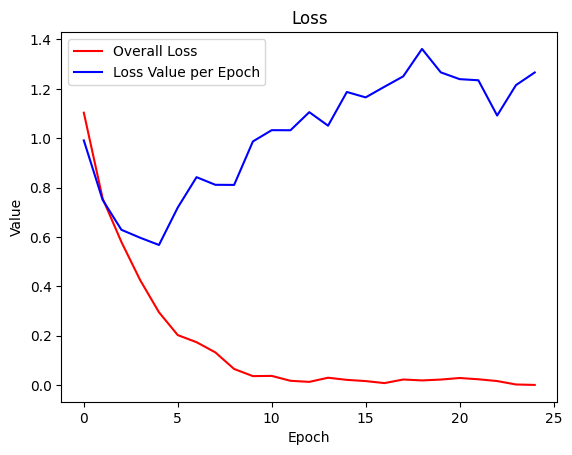

In [20]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r', label='Overall Loss')
plt.plot(hist.history['val_loss'], 'b', label='Loss Value per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

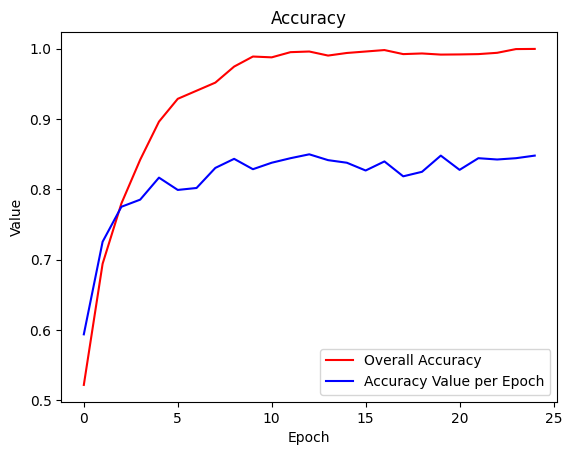

In [21]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r', label='Overall Accuracy')
plt.plot(hist.history['val_accuracy'], 'b', label='Accuracy Value per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()